----------------------------------------------------
# Predicting stock market prices

### Donald Trumps Tweets & Stock Market Prices

This file contains all scraping, API and analysis for the whole project


-------------------------------
# 0. Package install

In [78]:
#imports
import numpy as np

import pandas as pd
from pandas import Series

import seaborn as sns

from datetime import datetime, timezone, timedelta

from math import sqrt

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

import requests

import sklearn
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, validation_curve, TimeSeriesSplit
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cross_validation import train_test_split

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pd.options.display.max_colwidth = 400 #So we get the whole length of the tweet

#import sys
#sys._enablelegacywindowsfsencoding()

-----------------------------------

# 1. Scraping of Donald Trumps Tweets

We choose to use the archive:

http://www.trumptwitterarchive.com/archive 

For the scraping we use a few functions for the date format, and one function for the scraping and formatting of dates, this function is called 'tweets_by_year'. 

-------------------------------------

Functions for dateformat

In [3]:
#_______________________________________
def GiveDate(x): #YYYY MM DD HH:MM:SS
    Date = x.split()
    return "{} {} {} {}".format(Date[5], Date[1], Date[2], Date[3])

#_______________________________________
def GiveTime(x): #HH:MM:SS
    Time = x.split()
    return "{}".format(Time[3])

#_______________________________________
def GiveDay(x): #DD
    Day = x.split()
    return "{}".format(Day[0])

## 1.1 Function for scraping of tweets

In [5]:
#_______________________________________
def tweets_by_year(x):
    #from 2018 the response link has been changes, therefore there is two URL's
    url = "http://d5nxcu7vtzvay.cloudfront.net/data/realdonaldtrump/{year}.json".format(year = x)
    url_2018 = "http://www.trumptwitterarchive.com/data/realdonaldtrump/{year}.json".format(year = x)
    
    #_______________________________________
    #This will choose which link to use 
    if x == 2018 :
        response = requests.get(url_2018).json()
    else :
        response = requests.get(url).json()
    
    #_______________________________________
    #Converts date before dataframe
    for date in response:
        date['day_date'] = GiveDate(date['created_at'])
    
     #Converts time before dataframe
    for time in response:
        time['time'] = GiveTime(time['created_at'])
    
    #Converts day before dataframe
    for day in response:
        day['day'] = GiveDay(day['created_at'])
    
    #_______________________________________
    #Converts the response to a dataframe 
    tweets = pd.DataFrame(response)
    
    #_______________________________________
    #Makes new date, and year column for later use 
    tweets['date'] = pd.to_datetime(tweets['day_date'])#.apply(lambda x:x.strftime('%Y%m%d'))
    tweets['year'] = tweets.created_at.apply(lambda x: x[-4:])
    
    #_______________________________________
    #Push day four hours
    tweets['p_date'] = tweets['date'] + pd.Timedelta(hours=4) 
    #Gives the daynumber of the week 0-6
    tweets['p_day'] = tweets['p_date'].dt.weekday
    
    #_______________________________________
    #Indexes by the date
    tweets.set_index('date')

    return tweets

-----------
We are interested in the years after DT announced his candidacy, therefore we loop through the years we want to focus on, and create a dataframe for all the tweets from these years. This is done by having a list of years, and simply looping through, and for all years appending to one dataframe. 

In [7]:
#_______________________________________
years = [2015, 2016, 2017, 2018] #The years of interest 
dfMaster = pd.DataFrame() #An empty dataframe for apending of the data

#_______________________________________
#Loops through the years to collect all the tweets 
for i in years:
    df_tweet = pd.DataFrame()#makes a dataframe for each year
    df_tweet = tweets_by_year(i) 
    dfMaster = dfMaster.append(df_tweet, ignore_index=False) #Appends the year, and runs through next year

#_______________________________________    
All_Tweets = dfMaster #Gives the dataframe a new name

--------------
For the weekends (Saturday and Sunday) we had to push the tweets for next monday, after a lot of different approaches, we decided to split the data into 3, where each dataset got pushed the the appropriate time 

In [9]:
#_______________________________________
#Divides the dataset in saturday, sunday and weekdays (to push the weekendtweets and append on monday)
d_sat = All_Tweets.loc[All_Tweets['p_day']==5]
d_sun = All_Tweets.loc[All_Tweets['p_day']==6]
d_wee = All_Tweets.loc[All_Tweets['p_day'] < 5] 

#_______________________________________
#Pushes the days till next monday
d_sat['pp_date'] = d_sat['p_date'] + pd.Timedelta(hours=48)
d_sun['pp_date'] = d_sun['p_date'] + pd.Timedelta(hours=24)
d_wee['pp_date'] = d_wee['p_date'] + pd.Timedelta(hours=0)

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

After pushing the weekends, we combined the dataframes for one

In [11]:
#_______________________________________
#Merges the 3 datasets, so we end up with one, only containing weekdays and dates for the tweets
All_Tw_DT = pd.concat([pd.concat([d_sat, d_sun]), d_wee])

Before any other work, we need to change the dateformat for when we have to combine with the indexes

In [13]:
#_______________________________________
#Changes the format of the date, so we can combine with other data later
All_Tw_DT['pp_date'] = pd.to_datetime(All_Tw_DT['pp_date']).apply(lambda x:x.strftime('%Y-%m-%d'))

------------------------------------

## 1.2 Cleaning of data
We decided to drop the retweets, date before the announcement, and response tweets


In [15]:
#_______________________________________
# Drop retweets
All_Tweets_1 = All_Tw_DT[All_Tw_DT.is_retweet == False]

#_______________________________________
# Drop dates before announcement
All_Tweets_2 = All_Tweets_1[All_Tweets_1.pp_date >= '2015-06-16']

#_______________________________________
#Drop response tweets 
All_Tweets_3 = All_Tweets_2[~All_Tweets_2.text.str.startswith('"@')]

#_______________________________________
#Save for CSV
#All_Tweets_3.to_csv('All_3.csv')

--------------------
## 1.3 Sentiment analysis

For the sentiment analysis we used the Vader package

In [17]:
#_______________________________________
TW = All_Tweets_3.copy() #New dataframe

#_______________________________________
#Lists for the sentiment scores
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []

analyser = SentimentIntensityAnalyzer()

#_______________________________________
#Loop through the words in the tweets
for i in TW['text'] :
    vs_compound.append(analyser.polarity_scores(i)['compound'])
    vs_pos.append(analyser.polarity_scores(i)['pos'])
    vs_neu.append(analyser.polarity_scores(i)['neu'])
    vs_neg.append(analyser.polarity_scores(i)['neg'])

TW['sentiment'] = vs_compound
TW['positive'] = vs_pos
TW['neutral'] = vs_neu
TW['negative'] = vs_neg

Dropping the neutral tweets

In [19]:
#_______________________________________
t_t = TW[TW['sentiment'] != 0.000] #Drop neutral 

To get an impression of the average sentiment during a year

In [21]:
#_______________________________________
sentiment_mean_by_year = t_t.groupby('year')['sentiment'].mean() #Average
print(sentiment_mean_by_year)

year
2015    0.236441
2016    0.190019
2017    0.230733
2018    0.221367
Name: sentiment, dtype: float64


Descriptive statistics

In [23]:
#_______________________________________
#Descriptive stats
print(t_t['sentiment'].max())
print(t_t['sentiment'].min())
print(t_t['sentiment'].mean())

0.9899
-0.9864
0.2153132317073171


--------------------
## 1.4 Visualization

c:\programdata\miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


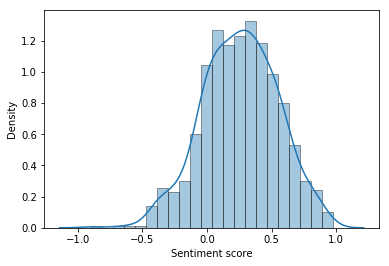

In [25]:
#_______________________________________
sentiment_mean_by_day = t_t.groupby('pp_date')['sentiment'].mean()
fig_1 = sns.distplot(sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


#fig_1.set_title('Average sentiment per day')
fig_1.set_xlabel('Sentiment score')
fig_1.set_ylabel('Density')
#fig_1.title.set_fontsize(14)
fig_1.xaxis.label.set_fontsize(10)
fig_1.yaxis.label.set_fontsize(10)
Fig1 = fig_1.get_figure()
Fig1.savefig('fig_2.png')

-------------------
## 1.5 Final dataframe for later use

In [27]:
#_______________________________________
retweet_by_day = t_t.groupby('pp_date')['retweet_count'].sum() #Sums the retweets per day
likes_by_day = t_t.groupby('pp_date')['favorite_count'].sum() #Sums the likes per day

#_______________________________________
rbd = retweet_by_day.to_frame()
rbd['pp_date'] = rbd.index
rbd.reset_index(drop=True)

lbd = likes_by_day.to_frame()
lbd['pp_date'] = lbd.index
lbd.reset_index(drop=True)

# Table with dates and the average sentiment
smbd = sentiment_mean_by_day.to_frame()
smbd['pp_date'] = smbd.index
smbd.reset_index(drop=True)

# Table with dates and the count of tweets per day  
count = t_t.groupby('pp_date')['text'].count()
count_t = count.to_frame()
count_t['pp_date'] = count_t.index
count_t.reset_index(drop=True)

#_______________________________________
# Merging of dates, sentiment per day, and count per day
Total = pd.merge(pd.merge(pd.merge(smbd, count_t, on='pp_date'), rbd, on='pp_date'), lbd, on='pp_date' )
Total.columns = ['avr_sentiment_per_day', 'date', 'count_per_day', 'retweet_per_day', 'likes_per_day']


c:\programdata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: FutureWarning: 'pp_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


Saving as CSV file

In [29]:
#_______________________________________
Total.to_csv('tweet_sentiment_data.csv')

-----------------------------------

# 2. API for stock market price index

First we need to define some functions we will use to clean and prep the data.

In [31]:
#_______________________________________
def change_pct(data, n):
    return data.pct_change(n)

#_______________________________________
def Change_to_bool(df):
    change_bool = []

    for x in df['change']:
        if x > 0:
            change_bool.append(1)
        else:
            change_bool.append(0)

    df["change_bool"] = change_bool

## 2.1 Function
Then we will create a function that gets the data from our API call, and uses the clean & prep functions. 

In [33]:
#_______________________________________
def alphavantage_call(index, apikey, req_type ="TIME_SERIES_DAILY_ADJUSTED", size = "full", from_date = "full"):   
    import pandas as pd 
    import datetime
    
    base = "https://www.alphavantage.co/query?function={rtype}&symbol={sindex}&outputsize={osize}&apikey={KEY}&datatype=csv".format(
        rtype=req_type, #formating variables
        sindex = index,
        KEY = apikey,
        osize=size)

    df = pd.read_csv(base) #read the csv file
    
    df["Index"] = index # create a column with the index name
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])# change the time stamp
    
    df_2 = df.sort_values(by=["timestamp"]) #sort values and store it in a new data_base
    
    df_2["change"] = change_pct(df_2["close"], 1) #calculate the difference in procentage
    
    Change_to_bool(df_2) #create a new column with a boolean value for when it goes up/down where 1= up and 0 = down

    if from_date == "full":  #return the output based on the optional argument from_date
        return df_2
    else:
        in_range_df = df_2[df_2["timestamp"].isin(pd.date_range(from_date, datetime.datetime.today().strftime('%Y-%m-%d')))]
        return in_range_df

Parameters for the function

In [35]:
#Params
API_KEY = "8BJZGWY3NP875LW7"
start_date = "2015-06-16"

Calling the function

In [37]:
IXIC = alphavantage_call(apikey=API_KEY, index="IXIC", from_date = start_date) #Nasdaq
DJ = alphavantage_call(apikey=API_KEY, index="DJI", from_date = start_date) #Dow Jones

df_concat = pd.concat([IXIC, DJ], axis=1) #Merging the data

In [38]:
df_ixic = df_concat.iloc[:,[0,5,6,10,11]]
df_i = df_ixic.rename(columns = {'adjusted_close':'close_ixic', 'volume':'vol_ixic','change':'change_ixic','change_bool':'change_ixic_bool'})
df_dj = df_concat.iloc[:,[17,18,22,23]]
df_d = df_dj.rename(columns = {'adjusted_close':'close_dj', 'volume':'vol_dj','change':'change_dj','change_bool':'change_dj_bool'})
df = pd.concat([df_i, df_d], axis=1)

df.to_csv('stock.csv')

------------------------
## 2.2 Visualization of the data



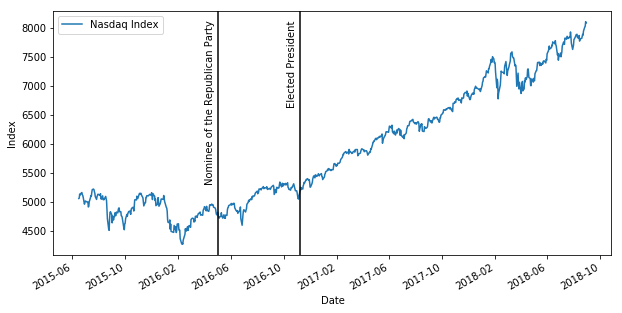

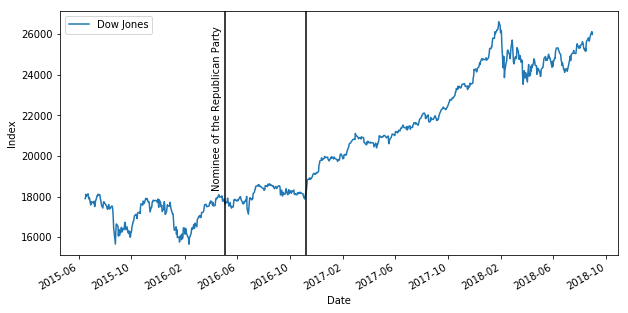

In [40]:
IXIC.plot(x='timestamp', y = 'close', figsize=(10,5), label='Nasdaq Index');
plt.axvline('2016-05-03', color='k');plt.axvline('2016-11-08', color='k');
plt.xlabel('Date');plt.ylabel('Index'); 
plt.annotate('Nominee of the Republican Party', xy = ('2016-04-03',8000), rotation = 90);
plt.annotate('Elected President', xy = ('2016-10-08',8000), rotation = 90)


DJ.plot(x='timestamp', y = 'close', figsize=(10,5), label='Dow Jones');
plt.axvline('2016-05-03', color='k');plt.axvline('2016-11-08', color='k');
plt.xlabel('Date');plt.ylabel('Index'); 
plt.annotate('Nominee of the Republican Party', xy = ('2016-04-03', 26000), rotation = 90);
#plt.annotate('Elected President', xy = ('2016-10-08', 26000), rotation = 90)



-----------------------------------
# 3. Combining the data

In [82]:
# Reading of files
stock = pd.read_csv('C:/Users/stock.csv', index_col=0)
trump = pd.read_csv('C:/Users/tweet_sentiment_data.csv', index_col=0)
stocks = stock.rename(index =str, columns = {'timestamp':'date'})

#Merging it all
s_t=pd.merge(trump, stocks, how='outer', on='date')
s_t

#Finding variables without observations
s_t.isnull().sum()

avr_sentiment_per_day    14
date                      0
count_per_day            14
retweet_per_day          14
likes_per_day            14
close_ixic               28
vol_ixic                 28
change_ixic              28
change_ixic_bool         28
close_dj                 28
vol_dj                   28
change_dj                28
change_dj_bool           28
dtype: int64

We decided to fill out the the N/A for tweets, with 0. Thoose days gets readed as days without any tweets. 

In [83]:
s_t['avr_sentiment_per_day'] = s_t['avr_sentiment_per_day'].fillna(0)
s_t['count_per_day'] = s_t['count_per_day'].fillna(0)
s_t['retweet_per_day'] = s_t['retweet_per_day'].fillna(0)
s_t['likes_per_day'] = s_t['likes_per_day'].fillna(0)
s_t['dates'] = pd.to_datetime(s_t['date'])
s_t.sort_values('dates')

,avr_sentiment_per_day,date,count_per_day,retweet_per_day,likes_per_day,close_ixic,vol_ixic,change_ixic,change_ixic_bool,close_dj,vol_dj,change_dj,change_dj_bool,dates
0,0.467650,2015-06-16,8.0,18874.0,23453.0,5056.0,1.654820e+09,0.005169,1.0,17904.4805,77510000.0,0.006369,1.0,2015-06-16
1,0.491114,2015-06-17,7.0,1140.0,3378.0,5065.0,1.712820e+09,0.001780,1.0,17935.7402,92410000.0,0.001746,1.0,2015-06-17
2,0.323700,2015-06-18,5.0,823.0,2000.0,5133.0,1.877920e+09,0.013425,1.0,18115.8398,94460000.0,0.010041,1.0,2015-06-18
3,-0.105250,2015-06-19,10.0,2729.0,4464.0,5117.0,2.468310e+09,-0.003117,0.0,18015.9492,258300000.0,-0.005514,0.0,2015-06-19
4,0.191129,2015-06-22,28.0,10745.0,19072.0,5154.0,1.619970e+09,0.007231,1.0,18119.7793,77780000.0,0.005763,1.0,2015-06-22
5,0.164300,2015-06-23,4.0,462.0,999.0,5160.0,1.613540e+09,0.001164,1.0,18144.0703,75970000.0,0.001341,1.0,2015-06-23
6,0.161700,2015-06-24,4.0,748.0,2111.0,5122.0,1.628800e+09,-0.007364,0.0,17966.0703,104980000.0,-0.009810,0.0,2015-06-24
7,0.114313,2015-06-25,15.0,8331.0,14420.0,5112.0,1.614760e+09,-0.001952,0.0,17890.3594,78990000.0,-0.004214,0.0,2015-06-25
8,0.611300,2015-06-26,4.0,3082.0,4990.0,5081.0,3.843810e+09,-0.006064,0.0,17946.6797,158120000.0,0.003148,1.0,2015-06-26
9,-0.024307,2015-06-29,15.0,9354.0,15477.0,4958.0,2.025580e+09,-0.024208,0.0,17596.3496,116340000.0,-0.019521,0.0,2015-06-29


The observations for stock market with N/A gets valued by taking the value from the day before and after, divided by 2

In [85]:
s_t['close_ixic'] = ((s_t['close_ixic'].fillna(method='bfill') + s_t['close_ixic'].fillna(method='ffill'))/2)
s_t['vol_ixic'] = ((s_t['vol_ixic'].fillna(method='bfill') + s_t['vol_ixic'].fillna(method='ffill'))/2)
s_t['vol_dj'] = ((s_t['vol_dj'].fillna(method='bfill') + s_t['vol_dj'].fillna(method='ffill'))/2)
s_t['close_dj'] = ((s_t['close_dj'].fillna(method='bfill') + s_t['close_dj'].fillna(method='ffill'))/2)
s_t['change_dj'] = ((s_t['change_dj'].fillna(method='bfill') + s_t['change_dj'].fillna(method='ffill'))/2)
s_t['change_ixic'] = ((s_t['change_ixic'].fillna(method='bfill') + s_t['change_ixic'].fillna(method='ffill'))/2)

Does the market go up or down - Boolean value

In [86]:
s_t.drop(columns = ['change_ixic_bool','change_dj_bool'])

#New boolean indicator for Nasdaq
change_bool = []
for x in s_t['change_ixic']:
    if x > 0:
        change_bool.append(1)
    else:
        change_bool.append(0)

s_t["change_ixic_bool"] = change_bool

#New boolean indicator for Dow Jones
change_bool = []
for x in s_t['change_dj']:
    if x > 0:
        change_bool.append(1)
    else:
        change_bool.append(0)

s_t["change_dj_bool"] = change_bool

In [87]:
#Finding missing observations
s_t.isnull().sum() #There should be none

avr_sentiment_per_day    0
date                     0
count_per_day            0
retweet_per_day          0
likes_per_day            0
close_ixic               0
vol_ixic                 0
change_ixic              0
change_ixic_bool         0
close_dj                 0
vol_dj                   0
change_dj                0
change_dj_bool           0
dates                    0
dtype: int64

In [88]:
#Copy for final merged
nas_trump = s_t.copy()

#Saves as csv
nas_trump.to_csv('final_merged.csv')

-------------------
# 4. Analysing 

First we want to split the data into 2, one for Dow Jones and one for Nasdaq

In [221]:
nas_trump['timepassed'] = nas_trump.index.copy().astype(int) #format change so we can have a quantitative time variable

nas_trump = nas_trump.rename(index =str, columns = {'avr_sentiment_per_day':'sentiment','retweet_per_day':'retweet', 'likes_per_day':'favourite', 'count_per_day':'tweet_count'})

dj_trump = nas_trump[['sentiment', 'timepassed','retweet','favourite','tweet_count', 'vol_dj']].copy()
ixic_trump = nas_trump[['sentiment','timepassed','retweet','favourite','tweet_count','vol_ixic']].copy()

----------------------------------------------
## 4.1 Split - Dow Jones
After dividing, the data, we have to split using TimeSeriesSplit, and therefore cross validating

Observations: 281
Training Observations: 142
Testing Observations: 139
Observations: 420
Training Observations: 281
Testing Observations: 139
Observations: 559
Training Observations: 420
Testing Observations: 139
Observations: 698
Training Observations: 559
Testing Observations: 139
Observations: 837
Training Observations: 698
Testing Observations: 139


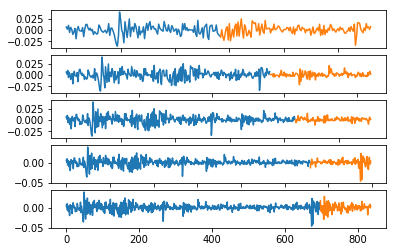

In [222]:
X1 = dj_trump.values
X = sm.add_constant(X1)
splits = TimeSeriesSplit(n_splits=5)

for train_index, test_index in splits.split(X):
	X_train = X[train_index]
	X_test = X[test_index]
pyplot.show()

Y = nas_trump['change_dj'].values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
	y_train = Y[train_index]
	y_test = Y[test_index]
	print('Observations: %d' % (len(y_train) + len(y_test)))
	print('Training Observations: %d' % (len(y_train)))
	print('Testing Observations: %d' % (len(y_test)))
	pyplot.subplot(510 + index)
	pyplot.plot(y_train)
	pyplot.plot([None for i in y_train] + [x for x in y_test])
	index += 1
pyplot.show()

-------------------------
### 4.1.1 Linear regression

In [223]:
reg=linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.coef_
a=reg.predict(X_test)
print((np.mean((a-y_test)**2))**1/2)

# R Squared
print(sklearn.metrics.r2_score(y_test, a))

3.512662679730675e-05
-0.007435414425834841


-------------------------------
## 4.2 Analysing the Dow Jones data

### 4.2.1 OLS regression

In [224]:
Y = nas_trump['change_dj'].values
ols_model = sm.OLS(Y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.528
Date:                Fri, 31 Aug 2018   Prob (F-statistic):              0.166
Time:                        12:00:17   Log-Likelihood:                 2849.3
No. Observations:                 837   AIC:                            -5685.
Df Residuals:                     830   BIC:                            -5652.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.575      0.5

-----------------------------------
### 4.2.2 Pipeline

In [225]:
pipe_preproc = make_pipeline(PolynomialFeatures(), StandardScaler())

# apply preproc - fit on train
pipe_preproc.fit(X_train) # fit to training
X_train_prep = pipe_preproc.transform(X_train) # transform training data
X_test_prep = pipe_preproc.transform(X_test) # transform test data


-----------------------------------
#### 4.2.2.1 Pipeline linear

In [226]:
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

----------------------------------------
#### 4.2.2.2 Pipeline LASSO

In [257]:
perform_las_dj = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_train)
    mse1 = mse(y_pred, y_train)
    perform_las_dj.append(sqrt(mse1))
    
hyperparam_perform_las_dj = pd.Series(perform_las_dj,index=lambdas)

optimal_las_dj = hyperparam_perform_las_dj.nsmallest(1)    
print(optimal_las_dj)

pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_las_dj.index[0]))
pipe_lasso.fit(X_train,y_train)

0.0001    0.007956
dtype: float64


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

Parameterestimates

In [258]:
las = linear_model.Lasso(alpha=optimal_las_dj.index[0])
las.fit(X_train, y_train)
las.coef_

array([ 0.00000000e+00, -0.00000000e+00,  6.27603868e-06, -6.79680705e-09,
        1.27296316e-09,  3.28308730e-05, -8.48333477e-12])

--------------------------------------
#### 4.2.2.3 Pipeline Ridge

In [262]:
perform_rid_dj = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_train)
    mse2 = mse(y_pred, y_train)
    perform_rid_dj.append(sqrt(mse2))
    
hyperparam_perform_rid_dj = pd.Series(perform_rid_dj,index=lambdas)

optimal_rid_dj = hyperparam_perform_rid_dj.nsmallest(1)    
print(optimal_rid_dj)

pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=optimal_rid_dj.index[0]))
pipe_ridge.fit(X_train,y_train)

0.0001    0.007832
dtype: float64


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [263]:
rid = linear_model.Ridge(alpha=optimal_rid_dj.index[0])
rid.fit(X_train, y_train)
rid.coef_

c:\programdata\miniconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.338949e-24
  overwrite_a=True).T


array([ 0.00000000e+00, -4.70736847e-04,  6.45697506e-06, -7.62648625e-09,
        1.36357662e-09,  3.59267702e-05, -8.49203914e-12])

------------------------------------
#### 4.2.2.4 Print of RMSE

In [265]:
print('LinReg', round(sqrt(mse(pipe_lr.predict(X_test),y_test)), 10))
print('Ridge', round(sqrt(mse(pipe_ridge.predict(X_test),y_test)), 10))
print('Lasso', round(sqrt(mse(pipe_lasso.predict(X_test),y_test)), 10))

LinReg 0.0095466162
Ridge 0.0095464846
Lasso 0.0083563873


------------------------------------------
## 4.3 Split - IXIC

Observations: 281
Training Observations: 142
Testing Observations: 139
Observations: 420
Training Observations: 281
Testing Observations: 139
Observations: 559
Training Observations: 420
Testing Observations: 139
Observations: 698
Training Observations: 559
Testing Observations: 139
Observations: 837
Training Observations: 698
Testing Observations: 139


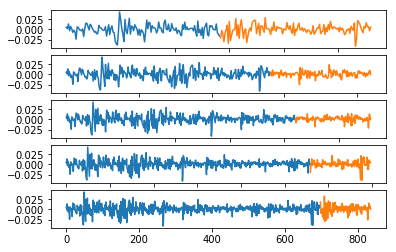

In [232]:
X2 = ixic_trump.values
X_ix = sm.add_constant(X2)
splits = TimeSeriesSplit(n_splits=5)

for train_index, test_index in splits.split(X):
	X_train_i = X[train_index]
	X_test_i = X[test_index]
pyplot.show()

Y = nas_trump['change_ixic'].values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
	y_train_i = Y[train_index]
	y_test_i = Y[test_index]
	print('Observations: %d' % (len(y_train_i) + len(y_test_i)))
	print('Training Observations: %d' % (len(y_train_i)))
	print('Testing Observations: %d' % (len(y_test_i)))
	pyplot.subplot(510 + index)
	pyplot.plot(y_train_i)
	pyplot.plot([None for i in y_train_i] + [x for x in y_test_i])
	index += 1
pyplot.show()

-------------------------------
### 4.3.1 Linear regression

In [1]:
reg=linear_model.LinearRegression()
reg.fit(X_train_i, y_train_i)
reg.coef_
a=reg.predict(X_test_i)
print((np.mean((a-y_test_i)**2))**1/2)

# R Squared
print(sklearn.metrics.r2_score(y_test_i, a))

NameError: name 'linear_model' is not defined

------------------------------------------------
## 4.2 Analysing the Nasdaq data

### 4.2.1 OLS regression

In [234]:
Y = nas_trump['change_ixic'].values
ols_model = sm.OLS(Y, X_ix)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.989
Date:                Fri, 31 Aug 2018   Prob (F-statistic):           3.83e-06
Time:                        12:00:22   Log-Likelihood:                 2727.8
No. Observations:                 837   AIC:                            -5442.
Df Residuals:                     830   BIC:                            -5408.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.002      4.606      0.0

----------------------------------
### 4.4.2 Pipeline

In [235]:
pipe_preproc = make_pipeline(PolynomialFeatures(), StandardScaler())

# apply preproc - fit on train
pipe_preproc.fit(X_train_i) # fit to training
X_train_prep = pipe_preproc.transform(X_train_i) # transform training data
X_test_prep = pipe_preproc.transform(X_test_i) # transform test data

-------------------------------------------------
#### 4.4.2.1 Pipeline linear

In [270]:
pipe_lr_i = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr_i.fit(X_train_i, y_train_i)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

----------------------
#### 4.4.2.2 Pipeline Lasso

In [267]:
perform_las_ix = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_lasso_i = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso_i.fit(X_train_i, y_train_i)
    y_pred_i = pipe_lasso.predict(X_train_i)
    mse1_i = mse(y_pred_i, y_train_i)
    perform_las_ix.append(sqrt(mse1_i))
    
hyperparam_perform_las_ix = pd.Series(perform_las_ix,index=lambdas)

optimal_las_ix = hyperparam_perform_las_ix.nsmallest(1)    
print(optimal_las_ix)

pipe_lasso_i = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_las_ix.index[0]))
pipe_lasso_i.fit(X_train_i,y_train_i)

0.0001    0.009375
dtype: float64


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

Parameter estimates

In [251]:
las_i = linear_model.Lasso(alpha=optimal_las_ix.index[0])
las_i.fit(X_train_i, y_train_i)
las_i.coef_

array([ 0.00000000e+00, -0.00000000e+00,  7.86761513e-06, -1.14993420e-08,
        1.71417475e-09,  5.45712256e-05, -9.06376038e-12])

-------------------------------------
#### 4.4.2.3 Pipeline Ridge

In [268]:
perform_rid_ix = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_ridge_i = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    pipe_ridge_i.fit(X_train_i, y_train_i)
    y_pred_i = pipe_ridge_i.predict(X_train_i)
    mse2_i = mse(y_pred_i, y_train_i)
    perform_rid_ix.append(sqrt(mse2_i))
    
hyperparam_perform_rid_ix = pd.Series(perform_rid_ix,index=lambdas)

optimal_rid_ix = hyperparam_perform_rid_ix.nsmallest(1)    
print(optimal_rid_ix)

pipe_ridge_i = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_rid_ix.index[0]))
pipe_ridge_i.fit(X_train_i,y_train_i)


0.0001    0.009241
dtype: float64


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

Parameter estimates

In [256]:
rid_i = linear_model.Ridge(alpha=optimal_rid_ix.index[0])
rid_i.fit(X_train_i, y_train_i)
rid_i.coef_

c:\programdata\miniconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.338949e-24
  overwrite_a=True).T


array([ 0.00000000e+00, -3.22911962e-04,  8.01386972e-06, -1.21637453e-08,
        1.78642578e-09,  5.77901156e-05, -9.07048222e-12])

-------------------------------------------
#### 4.4.2.4 Print of RMSE

In [271]:
print('LinReg', round(sqrt(mse(pipe_lr_i.predict(X_test_i),y_test_i)), 10))
print('Ridge', round(sqrt(mse(pipe_ridge_i.predict(X_test_i),y_test_i)), 10))
print('Lasso', round(sqrt(mse(pipe_lasso_i.predict(X_test_i),y_test_i)), 10))

LinReg 0.0104159804
Ridge 0.0096897472
Lasso 0.0096897472


---------------------------------
## 4.5 Learning Curves

In [242]:
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='neg_mean_squared_error',                 
                   cv=5)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head())

                Train      Test
sample size                    
55           0.000151  0.000068
111          0.000116  0.000065
167          0.000113  0.000065
223          0.000099  0.000065
279          0.000089  0.000065


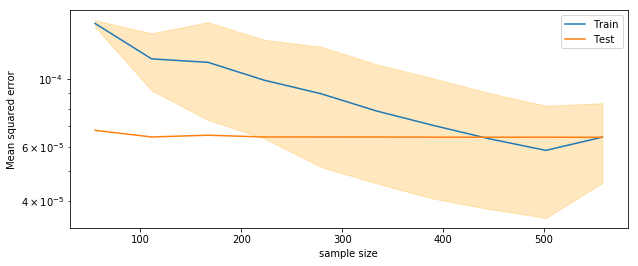

In [243]:
f_learn, ax = plt.subplots(figsize=(10,4))
mse_.plot(ax=ax, logy=True)
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')

f_learn.savefig("Leaning Curve.png")

-------------------------------------
# 5. Random forest


In [244]:
print(nas_trump['change_dj_bool'].sum()) #positives
print(nas_trump['change_ixic_bool'].sum()) #positives


dj_trump = nas_trump[['sentiment','retweet','favourite','tweet_count']]
ixic_trump = nas_trump[['sentiment','retweet','favourite','tweet_count']]


453
463


---------------------------------
## 5.1 Dow Jones

### 5.1.1 Split

Observations: 281
Training Observations: 142
Testing Observations: 139
Observations: 420
Training Observations: 281
Testing Observations: 139
Observations: 559
Training Observations: 420
Testing Observations: 139
Observations: 698
Training Observations: 559
Testing Observations: 139
Observations: 837
Training Observations: 698
Testing Observations: 139


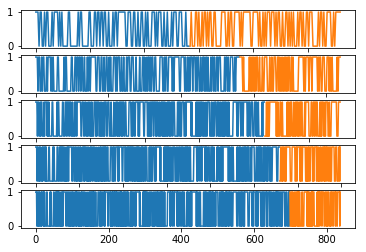

<Figure size 432x288 with 0 Axes>

In [245]:
X = dj_trump.values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
	X_train_dj = X[train_index]
	X_test_dj = X[test_index]

Y = nas_trump['change_dj_bool'].values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
	y_train_dj = Y[train_index]
	y_test_dj = Y[test_index]
	print('Observations: %d' % (len(y_train_dj) + len(y_test_dj)))
	print('Training Observations: %d' % (len(y_train_dj)))
	print('Testing Observations: %d' % (len(y_test_dj)))
	pyplot.subplot(510 + index)
	pyplot.plot(y_train_dj)
	pyplot.plot([None for i in y_train_dj] + [x for x in y_test_dj])
	index += 1

plt.show()
plt.savefig('SplitDJ.png')

------------------------------
### 5.1.2 Classification tree

In [246]:
#Classification tree Dow Jones
#Using the K fold cross validation method
kfolds = TimeSeriesSplit(n_splits=5)
accuracy_RF=[]
n_estimators_rng = np.unique(np.logspace(0,2,20).astype(np.int64))
for n in n_estimators_rng:
    
    RF_clf=DecisionTreeClassifier(random_state=1)  
    accuracy_ = []
    
    for train_idx, val_idx in kfolds.split(X_train_dj, y_train_dj):
        
        X_train_dj, y_train_dj, = X_train_dj, y_train_dj
        X_val_dj, y_val_dj = X_test_dj, y_test_dj 

        RF_clf.fit(X_train_dj, y_train_dj)
        
        y_hat_dj = RF_clf.predict(X_val_dj)
        
        accuracy_.append((accuracy_score(y_val_dj, y_hat_dj, normalize=True, sample_weight=None)))
          
    accuracy_RF.append(accuracy_)
                      
#Displaying the mean of the MSE of the different splits    
meanACC_RF= pd.DataFrame(accuracy_RF, index=n_estimators_rng).mean(axis=1)
optimalACC_RF=meanACC_RF.nsmallest(1)
print(optimalACC_RF)

1    0.496403
dtype: float64


-------------------------------
## 5.2 Nasdaq

### 5.2.1 Split

In [247]:
#Split for NASDAQ

X = ixic_trump.values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
	X_train_ix = X[train_index]
	X_test_ix = X[test_index]

Y = nas_trump['change_ixic_bool'].values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
	y_train_ix = Y[train_index]
	y_test_ix = Y[test_index]


<Figure size 432x288 with 0 Axes>

----------------------------------------------
### 5.2.2 Classification tree

In [248]:
#Classification tree NASDAQ
#Using the K fold cross validation method
kfolds = TimeSeriesSplit(n_splits=5)
accuracy_RF=[]
n_estimators_rng = np.unique(np.logspace(0,2,20).astype(np.int64))
for n in n_estimators_rng:
    
    RF_clf=DecisionTreeClassifier(random_state=1)  
    accuracy_ = []
    
    for train_ix, val_ix in kfolds.split(X_train_ix, y_train_ix):
        
        X_train_ix, y_train_ix, = X_train_ix, y_train_ix
        X_val_ix, y_val_ix = X_test_ix, y_test_ix 

        RF_clf.fit(X_train_ix, y_train_ix)
        
        y_hat_ix = RF_clf.predict(X_val_ix)
        
        accuracy_.append((accuracy_score(y_val_ix, y_hat_ix, normalize=True, sample_weight=None)))
          
    accuracy_RF.append(accuracy_)
                      
#Displaying the mean of the MSE of the different splits    
meanACC_RF= pd.DataFrame(accuracy_RF, index=n_estimators_rng).mean(axis=1)
optimalACC_RF=meanACC_RF.nsmallest(1)
print(optimalACC_RF)

1    0.539568
dtype: float64
